# NBA Data :: Predicting Game Points with Multiple Linear Regression

## Trevor Rowland :: 3-6-2025

This notebook aims to predict the amount of points in a given NBA game from historical game data.

## Table of Contents

## Importing Packages and Data

In [46]:
import numpy as np
import pandas as pd

import pandas as pd 
import numpy as np

# Set display options to show all columns and a large width
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Adjust the width as needed

%matplotlib inline
import matplotlib.pylab as plt


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from kneed import KneeLocator

In [47]:
gdrive_url = 'https://drive.google.com/file/d/1U2UaHWRSkUXfJBn4kBHPYttd3dvw_CZF/view?usp=drive_link'

file_id = '1U2UaHWRSkUXfJBn4kBHPYttd3dvw_CZF'
url = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(url, encoding='utf-8')
df = df[df['season'].str[:4].astype(int) > 2013] # Remove old seasons (this was causing issues)
df.head()

,game_id,season,team_id,team_name,tri_code,team_slug,minutes,field_goals_made,field_goals_attempted,field_goals_percentage,three_pointers_made,three_pointers_attempted,three_pointers_percentage,free_throws_made,free_throws_attempted,free_throws_percentage,rebounds_offensive,rebounds_defensive,rebounds_total,steals,blocks,turnovers,fouls_personal,points,plus_minus_points,estimated_offensive_rating,offensive_rating,estimated_defensive_rating,defensive_rating,estimated_net_rating,net_rating,assist_percentage,assist_to_turnover,assist_ratio,offensive_rebound_percentage,defensive_rebound_percentage,rebound_percentage,estimated_team_turnover_percentage,turnover_ratio,effective_field_goal_percentage,true_shooting_percentage,usage_percentage,estimated_usage_percentage,estimated_pace,pace,pace_per40,possessions,p_i_e,distance,rebound_chances_offensive,rebound_chances_defensive,rebound_chances_total,touches,secondary_assists,free_throw_assists,passes,assists,contested_field_goals_made,contested_field_goals_attempted,contested_field_goal_percentage,uncontested_field_goals_made,uncontested_field_goals_attempted,uncontested_field_goals_percentage,field_goal_percentage,defended_at_rim_field_goals_made,defended_at_rim_field_goals_attempted,defended_at_rim_field_goal_percentage,opponent_points,is_home_team,won_game,is_playoff_game,is_regular_game
13932,41400406,2014-15,1610612739,Cavaliers,CLE,cavaliers,240:00,32.0,82.0,0.390,6.0,26.0,0.231,27.0,39.0,0.692,16.0,40.0,56.0,3.0,7.0,16.0,26.0,97.0,-8.0,94.9,97.0,105.3,105.0,-10.3,-8.0,0.438,0.74,10.6,0.400,0.811,0.602,18.598,19.0,0.427,0.489,1.0,0.198,100.96,100.00,83.33,100.0,0.403,17.35,46.0,67.0,108.0,372.0,2.0,1.0,238.0,14.0,20.0,44.0,0.455,12.0,38.0,0.316,0.390,17.0,28.0,0.607,105.0,1,0,1,0
13933,41400405,2014-15,1610612744,Warriors,GSW,warriors,240:00,36.0,75.0,0.480,12.0,26.0,0.462,20.0,34.0,0.588,11.0,32.0,43.0,7.0,2.0,16.0,25.0,104.0,13.0,108.4,116.9,96.6,101.1,11.8,15.7,0.694,1.47,18.9,0.391,0.673,0.541,17.716,19.1,0.560,0.578,1.0,0.196,95.10,89.50,74.58,89.0,0.591,17.36,50.0,97.0,141.0,397.0,4.0,1.0,278.0,25.0,13.0,33.0,0.394,23.0,42.0,0.548,0.480,11.0,22.0,0.500,91.0,1,1,1,0
13934,41400404,2014-15,1610612739,Cavaliers,CLE,cavaliers,240:00,29.0,88.0,0.330,4.0,27.0,0.148,20.0,28.0,0.714,16.0,33.0,49.0,2.0,3.0,9.0,19.0,82.0,-21.0,87.9,90.1,114.6,113.2,-26.7,-23.1,0.552,1.78,12.8,0.355,0.818,0.547,9.644,9.9,0.352,0.409,1.0,0.203,91.60,91.00,75.83,91.0,0.325,16.78,45.0,50.0,92.0,411.0,4.0,2.0,290.0,16.0,19.0,46.0,0.413,10.0,42.0,0.238,0.330,9.0,14.0,0.643,103.0,1,0,1,0
13935,41400403,2014-15,1610612739,Cavaliers,CLE,cavaliers,240:00,35.0,76.0,0.461,9.0,21.0,0.429,17.0,24.0,0.708,6.0,37.0,43.0,9.0,8.0,14.0,16.0,96.0,5.0,99.4,104.3,99.7,97.8,-0.3,6.5,0.429,0.94,12.8,0.273,0.672,0.500,16.570,17.4,0.520,0.555,1.0,0.197,93.92,92.50,77.08,92.0,0.581,16.32,30.0,70.0,96.0,334.0,1.0,0.0,220.0,15.0,21.0,46.0,0.457,14.0,30.0,0.467,0.461,12.0,24.0,0.500,91.0,1,1,1,0
13936,41400402,2014-15,1610612744,Warriors,GSW,warriors,265:00,33.0,83.0,0.398,8.0,35.0,0.229,19.0,25.0,0.760,10.0,35.0,45.0,11.0,7.0,18.0,31.0,93.0,-2.0,90.3,89.4,85.9,91.3,4.4,-1.9,0.485,0.84,12.4,0.208,0.606,0.429,18.447,18.3,0.446,0.495,1.0,0.198,96.72,94.19,78.49,104.0,0.509,18.16,24.0,70.0,94.0,412.0,0.0,5.0,256.0,16.0,14.0,36.0,0.389,19.0,47.0,0.404,0.398,7.0,19.0,0.368,95.0,1,0,1,0


## Data Preprocessing

### PCA Results

In a PCA that Shake ran, we have the following lists of features:

In [48]:
feat_list_1 = ['possessions', 'contested_field_goals_made', 'is_home_team', 'estimated_team_turnover_percentage', 'defensive_rebound_percentage', 'defended_at_rim_field_goals_attempted', 'offensive_rebound_percentage', 'free_throws_made', 'estimated_usage_percentage', 'steals', 'free_throws_percentage', 'rebound_percentage', 'fouls_personal', 'effective_field_goal_percentage', 'assist_percentage', 'opponent_points']
feat_list_2 = ['defended_at_rim_field_goals_made', 'possessions', 'contested_field_goals_made', 'free_throws_percentage', 'fouls_personal', 'free_throws_attempted', 'rebound_chances_defensive', 'rebounds_offensive', 'contested_field_goals_attempted', 'is_home_team', 'estimated_team_turnover_percentage', 'defended_at_rim_field_goals_attempted', 'defended_at_rim_field_goal_percentage', 'rebound_percentage', 'free_throws_made', 'three_pointers_made', 'estimated_offensive_rating', 'defensive_rebound_percentage', 'assist_percentage', 'turnovers', 'opponent_points', 'passes', 'estimated_defensive_rating', 'estimated_pace', 'offensive_rebound_percentage', 'estimated_usage_percentage', 'touches', 'steals', 'effective_field_goal_percentage']

# Add Dependent Variables In:
feat_list_1.append('points')
feat_list_2.append('points')

We will create models of both `feat_list_1` and `feat_list_2` and compare the two.

In [49]:
df_numeric = df.select_dtypes('number') # Filter for only numbers

to_drop = ['game_id','team_id'] # Drop IDs
df_dropped_ids = df_numeric.drop(to_drop, axis=1).dropna()

df_pca_1 = df_dropped_ids[feat_list_1]
df_pca_2 = df_dropped_ids[feat_list_2]

df_pca_1.head()

,possessions,contested_field_goals_made,is_home_team,estimated_team_turnover_percentage,defensive_rebound_percentage,defended_at_rim_field_goals_attempted,offensive_rebound_percentage,free_throws_made,estimated_usage_percentage,steals,free_throws_percentage,rebound_percentage,fouls_personal,effective_field_goal_percentage,assist_percentage,opponent_points,points
13932,100.0,20.0,1,18.598,0.811,28.0,0.400,27.0,0.198,3.0,0.692,0.602,26.0,0.427,0.438,105.0,97.0
13933,89.0,13.0,1,17.716,0.673,22.0,0.391,20.0,0.196,7.0,0.588,0.541,25.0,0.560,0.694,91.0,104.0
13934,91.0,19.0,1,9.644,0.818,14.0,0.355,20.0,0.203,2.0,0.714,0.547,19.0,0.352,0.552,103.0,82.0
13935,92.0,21.0,1,16.570,0.672,24.0,0.273,17.0,0.197,9.0,0.708,0.500,16.0,0.520,0.429,91.0,96.0
13936,104.0,14.0,1,18.447,0.606,19.0,0.208,19.0,0.198,11.0,0.760,0.429,31.0,0.446,0.485,95.0,93.0


In [50]:
df_pca_2.head()

,defended_at_rim_field_goals_made,possessions,contested_field_goals_made,free_throws_percentage,fouls_personal,free_throws_attempted,rebound_chances_defensive,rebounds_offensive,contested_field_goals_attempted,is_home_team,estimated_team_turnover_percentage,defended_at_rim_field_goals_attempted,defended_at_rim_field_goal_percentage,rebound_percentage,free_throws_made,three_pointers_made,estimated_offensive_rating,defensive_rebound_percentage,assist_percentage,turnovers,opponent_points,passes,estimated_defensive_rating,estimated_pace,offensive_rebound_percentage,estimated_usage_percentage,touches,steals,effective_field_goal_percentage,points
13932,17.0,100.0,20.0,0.692,26.0,39.0,67.0,16.0,44.0,1,18.598,28.0,0.607,0.602,27.0,6.0,94.9,0.811,0.438,16.0,105.0,238.0,105.3,100.96,0.400,0.198,372.0,3.0,0.427,97.0
13933,11.0,89.0,13.0,0.588,25.0,34.0,97.0,11.0,33.0,1,17.716,22.0,0.500,0.541,20.0,12.0,108.4,0.673,0.694,16.0,91.0,278.0,96.6,95.10,0.391,0.196,397.0,7.0,0.560,104.0
13934,9.0,91.0,19.0,0.714,19.0,28.0,50.0,16.0,46.0,1,9.644,14.0,0.643,0.547,20.0,4.0,87.9,0.818,0.552,9.0,103.0,290.0,114.6,91.60,0.355,0.203,411.0,2.0,0.352,82.0
13935,12.0,92.0,21.0,0.708,16.0,24.0,70.0,6.0,46.0,1,16.570,24.0,0.500,0.500,17.0,9.0,99.4,0.672,0.429,14.0,91.0,220.0,99.7,93.92,0.273,0.197,334.0,9.0,0.520,96.0
13936,7.0,104.0,14.0,0.760,31.0,25.0,70.0,10.0,36.0,1,18.447,19.0,0.368,0.429,19.0,8.0,90.3,0.606,0.485,18.0,95.0,256.0,85.9,96.72,0.208,0.198,412.0,11.0,0.446,93.0


In [51]:
print(f'There are {df_pca_1.isna().sum().sum()} missing values in the first df of PCA features.')
print(f'There are {df_pca_2.isna().sum().sum()} missing values in the second df of PCA features.')

There are 0 missing values in the first df of PCA features.
There are 0 missing values in the second df of PCA features.


### Removing High Correlation

Now we need to remove the independent variables that are highly correlated with each other. To do this, we have a function we can define:

In [52]:
'''
This function drops highly correlated variables given a threshold.
It drops the variable with smaller variance.

It returns:
1. The variables that were dropped
2. The data without the dropped variables
'''

def drop_highly_correlated(data, threshold=.7):
    from dython.nominal import associations
    cor_matrix = associations(dataset=data, compute_only=True)['corr'].abs()
    #cor_matrix = data.corr().abs()
    sol = (cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))).unstack().dropna()

    to_drop=[]
    for i in range(len(sol[sol > threshold].index.tolist())):
        var1 = sol[sol >= threshold].index.tolist()[i][0]
        var2 = sol[sol >= threshold].index.tolist()[i][1]

        if(data[var1].var() < data[var2].var()): 
            to_drop.append(var1)
        else: 
            to_drop.append(var2)

    dropped_vars = list(set(to_drop))
    return dropped_vars, data.drop(dropped_vars, axis=1) # (list of dropped vars, resultant df)

And here is a function to get a correlation heatmap of the results to check our work later.

In [53]:
def my_corrplot(df, dep_var):
    import seaborn as sns
    from dython.nominal import associations

    # create a correlation matrix of all predictor variables using 'associations'
    corr_matrix = associations(dataset=df.drop(dep_var, axis=1), compute_only=True)['corr']

    # Mask upper triangle of the corr heatmap ???
    mask_upper = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Plot
    plt.figure(figsize=(44,44))
    sns.heatmap(corr_matrix, annot=True, mask=mask_upper, fmt='.2f', vmin=-1, vmax=1)
    plt.show()

Now with these functions, we can split the dataframe into 2 components: `X`, the independent features, and `y`, the dependent variable. Then we can plug these into the function and remove the multicollinearity in the dataset.

In [54]:
# Split the Data
y1 = df_pca_1['points']
X1 = df_pca_1.drop(columns=['points'], axis=1)

y2 = df_pca_2['points']
X2 = df_pca_2.drop(columns=['points'], axis=1)

# Remove Multicollinearity
res1 = drop_highly_correlated(X1)
res2 = drop_highly_correlated(X2)

nu_X1 = res1[1] # X values with no multicollinearity from PCA list 1
nu_X2 = res2[1] # X values with no multicollinearity from PCA list 2

# Squish Variables back together
nu_pca_df_1 = pd.concat([y1,nu_X1], axis=1)
nu_pca_df_2 = pd.concat([y2,nu_X2], axis=1)

In [55]:
nu_pca_df_1.head()

,points,possessions,contested_field_goals_made,is_home_team,estimated_team_turnover_percentage,defensive_rebound_percentage,defended_at_rim_field_goals_attempted,offensive_rebound_percentage,free_throws_made,estimated_usage_percentage,steals,free_throws_percentage,fouls_personal,effective_field_goal_percentage,assist_percentage,opponent_points
13932,97.0,100.0,20.0,1,18.598,0.811,28.0,0.400,27.0,0.198,3.0,0.692,26.0,0.427,0.438,105.0
13933,104.0,89.0,13.0,1,17.716,0.673,22.0,0.391,20.0,0.196,7.0,0.588,25.0,0.560,0.694,91.0
13934,82.0,91.0,19.0,1,9.644,0.818,14.0,0.355,20.0,0.203,2.0,0.714,19.0,0.352,0.552,103.0
13935,96.0,92.0,21.0,1,16.570,0.672,24.0,0.273,17.0,0.197,9.0,0.708,16.0,0.520,0.429,91.0
13936,93.0,104.0,14.0,1,18.447,0.606,19.0,0.208,19.0,0.198,11.0,0.760,31.0,0.446,0.485,95.0


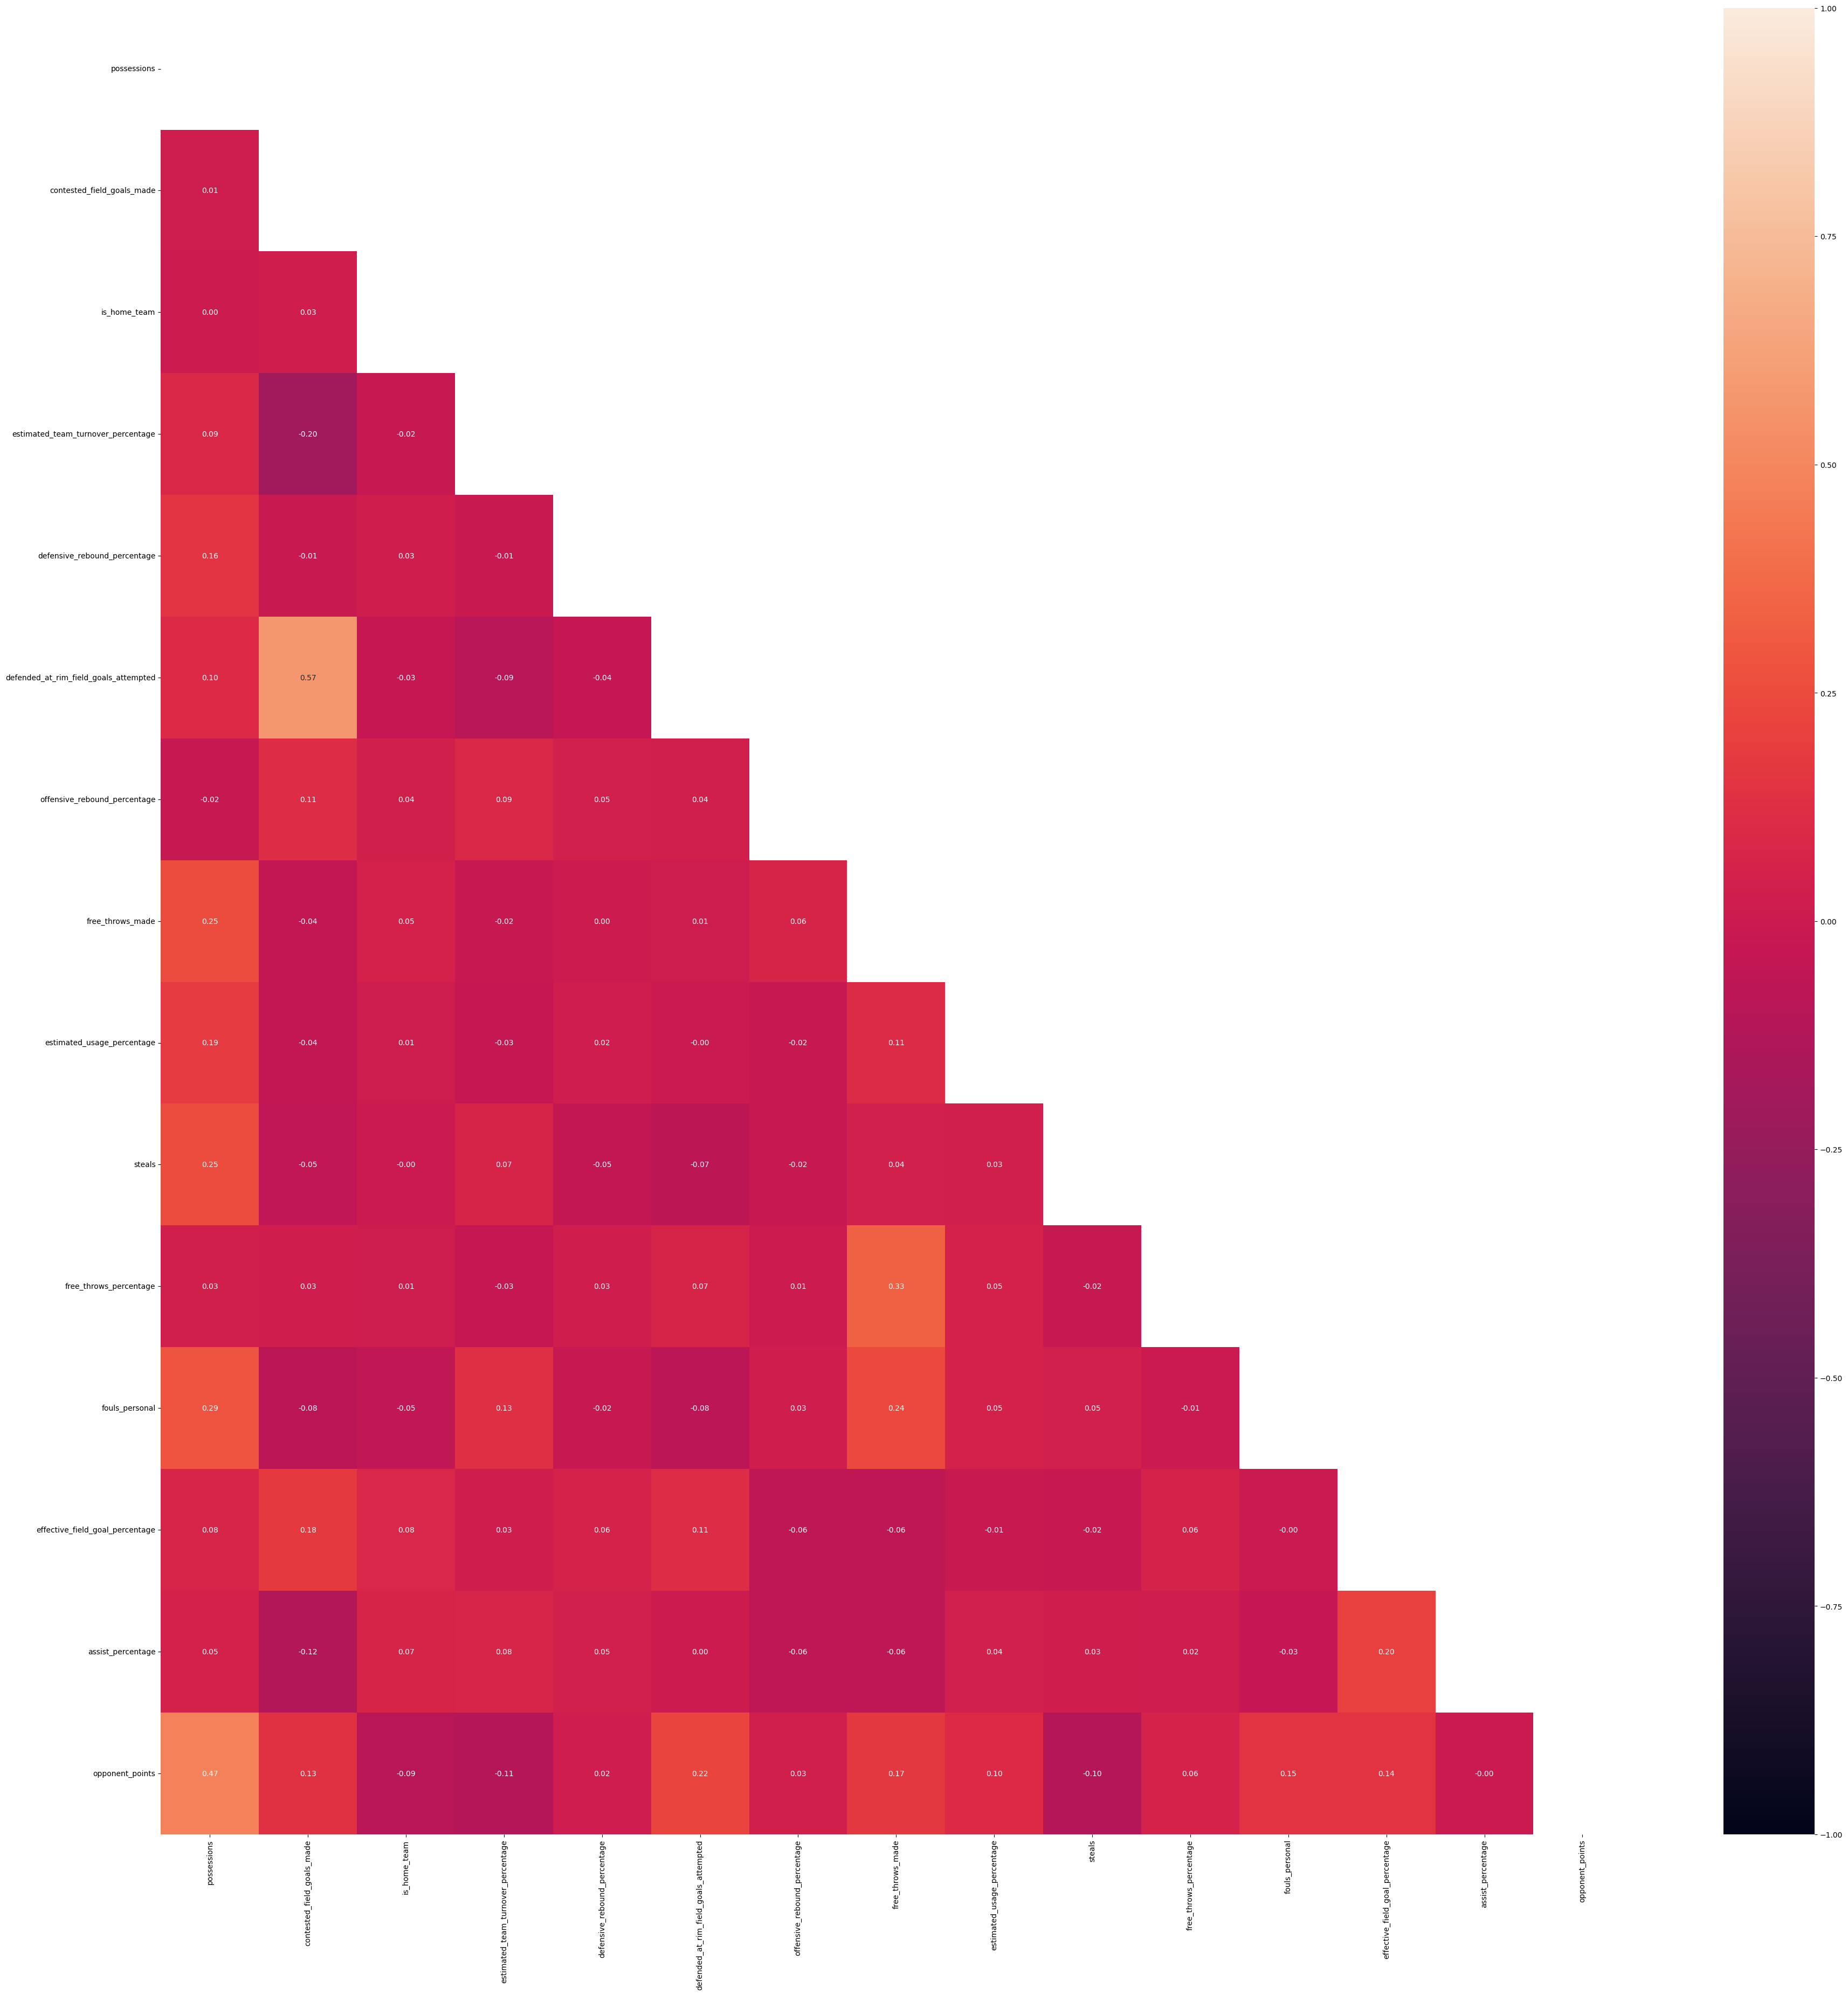

In [56]:
my_corrplot(nu_pca_df_1,'points')

In [57]:
nu_pca_df_2.head()

,points,possessions,free_throws_percentage,fouls_personal,free_throws_attempted,rebounds_offensive,is_home_team,three_pointers_made,estimated_offensive_rating,defensive_rebound_percentage,assist_percentage,turnovers,opponent_points,offensive_rebound_percentage,estimated_usage_percentage,touches,steals
13932,97.0,100.0,0.692,26.0,39.0,16.0,1,6.0,94.9,0.811,0.438,16.0,105.0,0.400,0.198,372.0,3.0
13933,104.0,89.0,0.588,25.0,34.0,11.0,1,12.0,108.4,0.673,0.694,16.0,91.0,0.391,0.196,397.0,7.0
13934,82.0,91.0,0.714,19.0,28.0,16.0,1,4.0,87.9,0.818,0.552,9.0,103.0,0.355,0.203,411.0,2.0
13935,96.0,92.0,0.708,16.0,24.0,6.0,1,9.0,99.4,0.672,0.429,14.0,91.0,0.273,0.197,334.0,9.0
13936,93.0,104.0,0.760,31.0,25.0,10.0,1,8.0,90.3,0.606,0.485,18.0,95.0,0.208,0.198,412.0,11.0


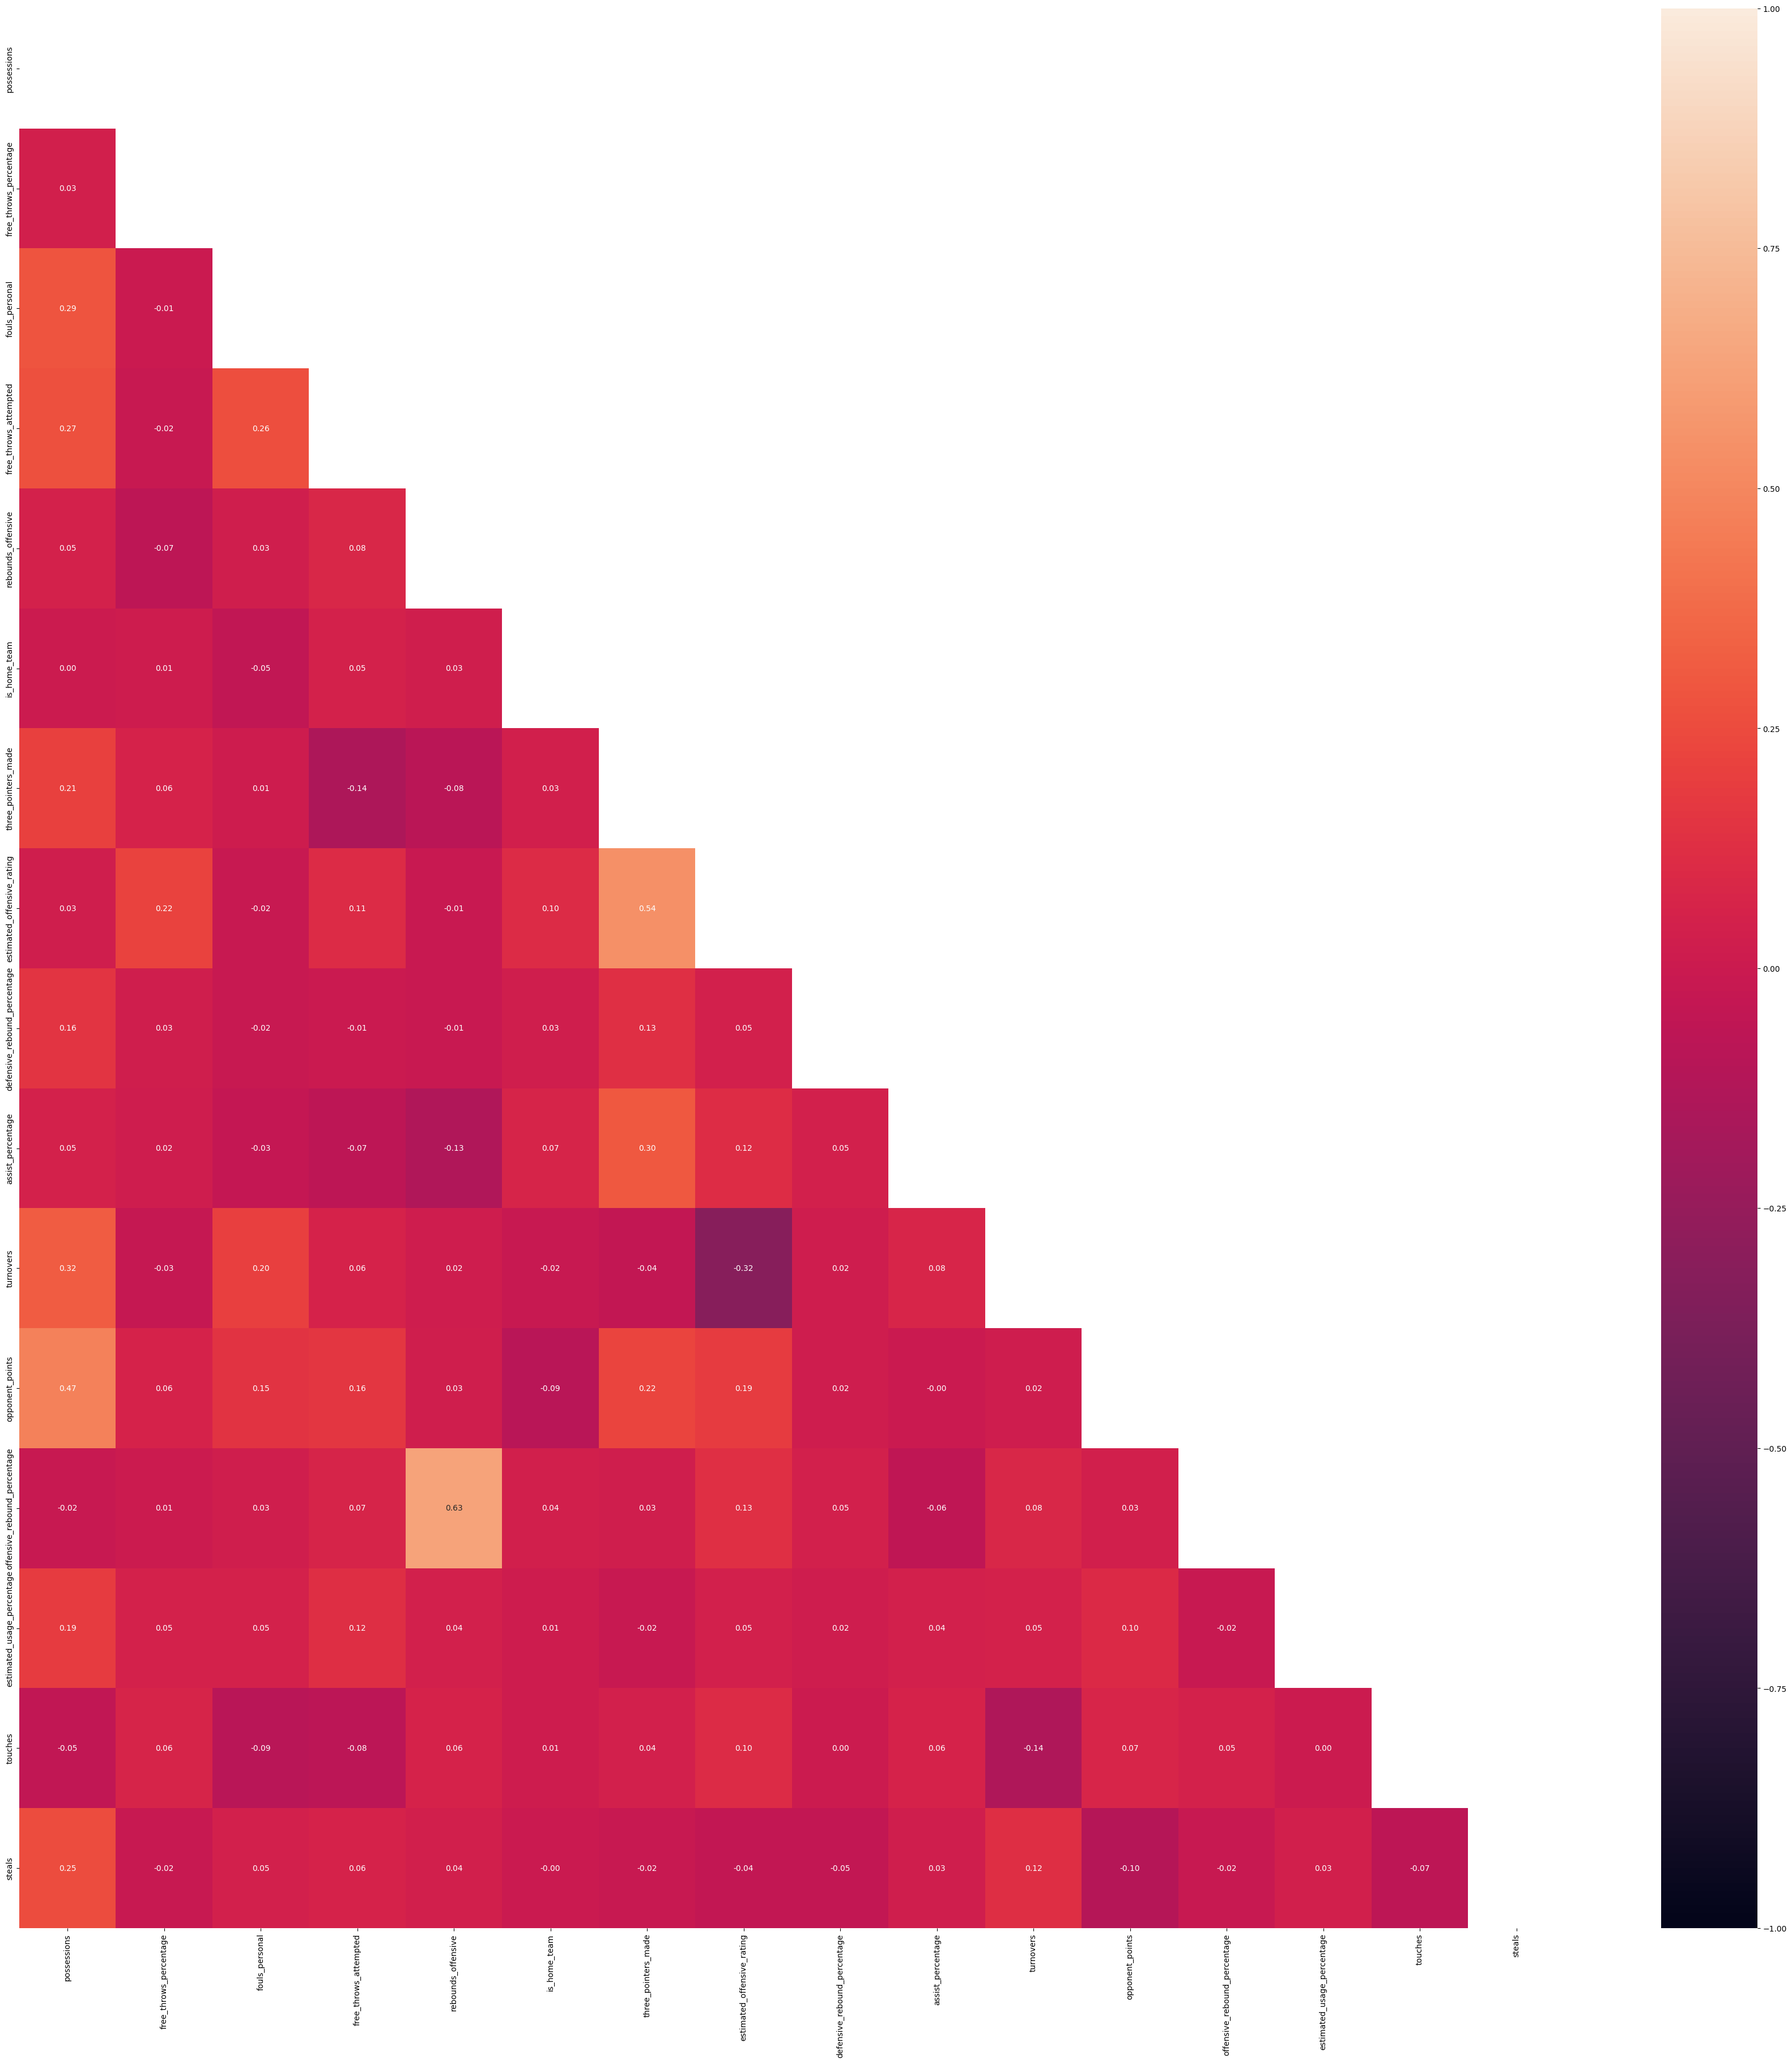

In [58]:
my_corrplot(nu_pca_df_2, 'points')

Now both datasets have no multicollinearity, and we can continue to preprocess the data.

### Removing Near-Zero Variance

Now we also need to remove variables with near-zero variance. This is to remove variables that may appear in the model but are not truly explanatory. Here is the function that removes these variables.

In [59]:
'''
remove_nzv_features removes features in the DataFrame with a variance below the parameter threshold. 
This is done by creating a mask using the sklearn VarianceThreshold function.

returns a tuple of the dataframe with the selected features (retained_df) and a dataframe of the dropped features (dropped_df)
'''
def remove_nzv_features(df:pd.DataFrame, threshold=.1): 
    from sklearn.feature_selection import VarianceThreshold

    vThreshold = VarianceThreshold(threshold)
    vThreshold.fit_transform(df)

    # Get boolean mask for selected columns
    mask = vThreshold.get_support()
    
    # Select columns to keep and drop
    selected_columns = df.columns[mask]
    dropped_columns = df.columns[~mask]
    
    # Create DataFrames for retained and removed features
    retained_df = df[selected_columns]
    dropped_df = df[dropped_columns]

    return retained_df, dropped_df


In [60]:
# Remove the Variance
res_nzv_1 = remove_nzv_features(nu_X1)
res_nzv_2 = remove_nzv_features(nu_X2)

# Assign them to new DFs
no_nzv_pca_df_1 = res_nzv_1[0]
no_nzv_pca_df_2 = res_nzv_2[0]

In [61]:
# Examine the Dropped Features
res_nzv_1[1].head()

,defensive_rebound_percentage,offensive_rebound_percentage,estimated_usage_percentage,free_throws_percentage,effective_field_goal_percentage,assist_percentage
13932,0.811,0.400,0.198,0.692,0.427,0.438
13933,0.673,0.391,0.196,0.588,0.560,0.694
13934,0.818,0.355,0.203,0.714,0.352,0.552
13935,0.672,0.273,0.197,0.708,0.520,0.429
13936,0.606,0.208,0.198,0.760,0.446,0.485


In [62]:
res_nzv_2[1].head()

,free_throws_percentage,defensive_rebound_percentage,assist_percentage,offensive_rebound_percentage,estimated_usage_percentage
13932,0.692,0.811,0.438,0.400,0.198
13933,0.588,0.673,0.694,0.391,0.196
13934,0.714,0.818,0.552,0.355,0.203
13935,0.708,0.672,0.429,0.273,0.197
13936,0.760,0.606,0.485,0.208,0.198


### Scaling

Lastly, we need to scale (or normalize) the data. This isn't necessary for MLR, but it is good practice for ML models we might use later.

In [63]:
def scale_features(df:pd.DataFrame):
    from sklearn.preprocessing import StandardScaler

    df_std = StandardScaler().fit_transform(df)
    cleaned = pd.DataFrame(df_std, columns=df.columns)
    orig_df = df

    return cleaned, orig_df

In [64]:
pca_df_scaled_1 = scale_features(no_nzv_pca_df_1)[0]
pca_df_scaled_2 = scale_features(no_nzv_pca_df_2)[0]

In [65]:
pca_df_scaled_1.head(10)

,possessions,contested_field_goals_made,is_home_team,estimated_team_turnover_percentage,defended_at_rim_field_goals_attempted,free_throws_made,steals,fouls_personal,opponent_points
0,0.131491,0.563353,1.0,1.170979,0.482855,1.573969,-1.579043,1.309824,-0.250139
1,-1.625774,-0.591103,1.0,0.941636,-0.195902,0.412374,-0.227159,1.084791,-1.278015
2,-1.306271,0.398431,1.0,-1.157296,-1.100912,0.412374,-1.917015,-0.265408,-0.396978
3,-1.146520,0.728275,1.0,0.643646,0.030350,-0.085452,0.448784,-0.940508,-1.278015
4,0.770497,-0.426181,1.0,1.131715,-0.535281,0.246432,1.124726,2.434990,-0.984336
5,0.131491,-0.920947,1.0,-0.502810,-0.648407,0.412374,0.110812,-0.940508,-0.617238
6,0.291242,-0.591103,1.0,0.851147,0.482855,0.578316,0.786755,2.209957,-1.351435
7,-0.827017,0.563353,1.0,-0.989839,0.482855,0.246432,-0.903101,-0.490441,-1.498274
8,1.409502,0.728275,1.0,0.430944,0.030350,1.242085,0.110812,-0.940508,0.484058
9,0.291242,0.233509,1.0,-0.407120,-0.422154,0.412374,-1.579043,0.859758,0.190379


In [66]:
pca_df_scaled_2.head(10)

,possessions,fouls_personal,free_throws_attempted,rebounds_offensive,is_home_team,three_pointers_made,estimated_offensive_rating,turnovers,opponent_points,touches,steals
0,0.131491,1.309824,2.196328,1.518257,1.0,-1.210848,-1.050861,0.594897,-0.250139,-0.100189,-1.579043
1,-1.625774,1.084791,1.518530,0.197895,1.0,0.246879,0.074760,0.594897,-1.278015,0.129327,-0.227159
2,-1.306271,-0.265408,0.705174,1.518257,1.0,-1.696757,-1.634516,-1.149597,-0.396978,0.257856,-1.917015
3,-1.146520,-0.940508,0.162936,-1.122467,1.0,-0.481984,-0.675654,0.096470,-1.278015,-0.449054,0.448784
4,0.770497,2.434990,0.298496,-0.066177,1.0,-0.724939,-1.434405,1.093324,-0.984336,0.267036,1.124726
5,0.131491,-0.940508,-0.108183,0.197895,1.0,-0.239030,0.158139,-0.401957,-0.617238,0.331301,0.110812
6,0.291242,2.209957,1.111852,2.310475,1.0,-0.481984,-0.600612,0.594897,-1.351435,0.827056,0.786755
7,-0.827017,-0.490441,0.976293,0.726040,1.0,0.489834,1.158691,-0.900384,-1.498274,-0.026744,-0.903101
8,1.409502,-0.940508,2.738565,-1.650611,1.0,1.461652,0.925229,0.594897,0.484058,0.166049,0.110812
9,0.291242,0.859758,0.840733,2.310475,1.0,0.732788,0.199829,-0.152743,0.190379,0.276217,-1.579043


Now we have 2 scaled dataframes to create the models with.

## MLR Model

### 1st set of PCA features (`feat_list_1`)

In [ ]:
from sklearn.model_selection import train_test_split

final_1 = pd.concat([pca_df_scaled_1, y1], axis=1).dropna()

X = final_1.loc[:, final_1.columns != 'points']
y = final_1.loc[:, final_1.columns == 'points']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2142)

In [68]:
import statsmodels.api as sm

train_X = sm.add_constant(X_train)

model = sm.OLS(y_train, train_X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 points   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     24.14
Date:                Thu, 06 Mar 2025   Prob (F-statistic):           4.06e-37
Time:                        15:31:37   Log-Likelihood:                -43177.
No. Observations:               10780   AIC:                         8.637e+04
Df Residuals:                   10771   BIC:                         8.644e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
possessions                               0.7481      0.166      4.502      0.000       0.422       1.074
contested_field_goals_made               -0.5726      0.159     -3.591      0.000      -0.885      -0.260
is_home_team                           -109.4155      0.130   -844.520      0.000    -109.669    -109.162
estimated_team_turnover_percentage       -0.2856      0.133     -2.152      0.031      -0.546      -0.025
defended_at_rim_field_goals_attempted     0.7641      0.157      4.854      0.000       0.456       1.073
free_throws_made                         -0.2260      0.137     -1.650      0.099      -0.494       0.042
steals                                   -0.0644      0.137     -0.468      0.639      -0.334       0.205
fouls_personal                           -0.3908      0.136     -2.873      0.004      -0.657      -0.124
opponent_points                           1.1185      0.159      7.056      0.000       0.808       1.429
==============================================================================
Omnibus:                      451.942   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1484.221
Skew:                           0.039   Prob(JB):                         0.00
Kurtosis:                       4.816   Cond. No.                         2.26
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""